# This algorithm interpolates the orbital elements of the major bodies in the solar system from Venus to Pluto for up to 18 million years.
## It requires the standard dependecies, numpy and scipy, and the local file methods.py.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import methods as me

from scipy.optimize import curve_fit
from scipy.signal import detrend

## Here, specify the directory of the folder where this file is placed.

In [ ]:
#  dir of this repo
dir_home = '/home/rmentel/interpolating-orbits/Github/'
dir_params = dir_home + 'params/'
dir_data = dir_home + 'data/'
# dir_data = '/home/rmentel/interpolating-orbits/'

In [4]:
# Define needed constants and labels
# AU to m
AU_to_M = 1.49598*10**11
# AU/y to m/s
AUpY_to_MpS = 4743.183
# solar mass to kg
SM_to_kg = 1.988435*10**30
# year to seconds
Year_to_s = 3.15569259936*10**7
# gravitational constant G[m^3/kg*s^2]
G = 6.67428*10**-11
# gravitational parameter mu
mu = 1.327137415503024*10**20
# number of bodies
n_b = 9
batchsize = 11

name_label = ['Sun', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']
oe_label = ['Semimajor Axis [AU]', 'Eccentricity', 'Inclination [Deg]', 'A. of periapsis [Rad]', 'L. of ascending node [Rad]']
sin_labels = ['Period [Years]', 'Amplitude', 'Phase', 'Offset']
planetperiods = np.array([0.6152, 1, 1.8808, 11.862, 29.447, 84.012, 164.789, 249.589])

## This section reads in the data from the simulation whose data we can interpolate.
### It is recommended to run this once to have the entire data set for 18 Myr for one planet, and then run the later parts of this script individually without reloading the simulation data.

In [5]:
# Read in ORIGINAL Brutus data
file = open(dir_data + 'run_N9_solar_system_jpl_0_0_0_t65Myr_e14_Lw128.diag', 'r')
body_o = file.readlines()[:]

# Number of snapshots in the simulation
steps = 182035
# steps = 1000

# Initiate the arrays to store the data
time_o = np.zeros((int(steps), 1))
cart_o = np.zeros((int(steps), n_b, 7))
kepl_o = np.zeros((int(steps), n_b, 7))

# Write array of cartesian parameters: Solar mass, AU, AU/Y
for i in range(int(steps)): # for all time steps ...
    batch = body_o[(batchsize*i):(batchsize*(i+1))]
    time_o[i, 0] = float((batch[0].split())[0])/6.28
    for j, line in enumerate(batch[1:-1]): # for all bodies...
        words = line.split()
        cart_o[i, j, :] = [float(x) for x in words]
        cart_o[i, j, 4:8] = 2*np.pi*cart_o[i, j, 4:8]

for i, step in enumerate(cart_o[:steps]):
    # Calculate COM:
    R_COM = np.zeros((1,3))
    V_COM = np.zeros((1,3))
    M = 0
    for j in range(8):
        m = SM_to_kg*step[j, 0]
        M = M + m
        R = AU_to_M*step[j, 1:4]
        V = AUpY_to_MpS*step[j, 4:7]
        R_COM = R_COM + m*R
        V_COM = V_COM + m*V
    r_COM = R_COM/M
    v_COM = V_COM/M   
    
#     For better runtime:
#     Only read in one body
#     for j in range(9):
    j = 3
    m = SM_to_kg*step[j, 0]
    R = AU_to_M*step[j, 1:4]
    V = AUpY_to_MpS*step[j, 4:8]
    r = (R - r_COM)[0]
    v = (V - v_COM)[0]
    # a, e, i, om, Om, M, E
    kepl_o[i, j, 0] = me.CartesianToKepler(m, r, v)[0]/AU_to_M
#     for k in range(6):
    k = 1
    kepl_o[i, j, k+1] = me.CartesianToKepler(m, r, v)[k+2]

In [6]:
def SMAtoPeriod(A):
    P = 2*np.pi*np.sqrt((A*AU_to_M)**3/mu)/Year_to_s
    return P

def MeanAngMotion(Per0, Per1):
    Per_Mean = (Per0 + Per1)*0.5
    N_mean = 2*np.pi/Per_Mean
    return N_mean

# For linear interpolation
def LinearInterpolate(Tau, Data):
    T0 = 100*int(Tau/100)
    DF = Data[1] - Data[0]
    DT = 100
    B = DF/DT
    A = Data[0] - B*T0
    F = A + B*Tau
    return F

def OneSin(T, Args):
    Per, Amp, Phase, Offset = Args
    F = Offset + Amp*np.sin(Phase + 2*np.pi*T/Per)
    return F

def TwoSin(T, Args):
    Per1, Amp1, Phase1, Offset, Per2, Amp2, Phase2 = Args
    Sin1 = Amp1*np.sin(Phase1 + 2*np.pi*T/Per1)
    Sin2 = Amp2*np.sin(Phase2 + 2*np.pi*T/Per2)
    F = Offset + Sin1 + Sin2
    return F

def ThreeSin(T, Args):
    Per1, Amp1, Phase1, Offset, Per2, Amp2, Phase2, Per3, Amp3, Phase3 = Args
    Sin1 = Amp1*np.sin(Phase1 + 2*np.pi*T/Per1)
    Sin2 = Amp2*np.sin(Phase2 + 2*np.pi*T/Per2)
    Sin3 = Amp3*np.sin(Phase3 + 2*np.pi*T/Per3)
    F = Offset + Sin1 + Sin2 + Sin3
    return F

offset, per, amp, per1, amp1, per2, amp2, per3, amp3 = 0,0,0,0,0,0,0,0,0
def FitOneSine(X, Phase, Offset):
    F = Offset + amp*np.sin(Phase + (2*np.pi/per)*X)
    return F

def FitTwoSine(X, Phase1, Phase2, Offset):
    Sine1 = amp1*np.sin(Phase1 + (2*np.pi/per1)*X)
    Sine2 = amp2*np.sin(Phase2 + (2*np.pi/per2)*X)
    F = Offset + Sine1 + Sine2
    return F

def FitThreeSine(X, Phase1, Phase2, Phase3, Offset):
    Sine1 = amp1*np.sin(Phase1 + (2*np.pi/per1)*X)
    Sine2 = amp2*np.sin(Phase2 + (2*np.pi/per2)*X)
    Sine3 = amp3*np.sin(Phase3 + (2*np.pi/per3)*X)
    F = Offset + Sine1 + Sine2 + Sine3
    return F

# This is the actual algorithm to interpolate the orbital elements.

## The orbital elements each have their own index when referred to them:
### 0: Semi-major axis (SMA)
### 1: Eccentricity (ECC
### 2: Inclination (INC)
### 3: Argument of Periapsis (AOP)
### 4: Longitude in Ascending Node (LAN)
### 5: Mean anomaly

### Only the mean anomaly won't be interpolated, but calculated locally.
In the beginning, provide the time tau and the body for which the orbital elements are desired.
The output is an array "output" of size (1,6) that holds the orbital elements for that body at tau.
The algorithm can give out plots of the interpolation of desired - for that, simply comment out the corresponding lines.

/home/rmentel/interpolating-orbits/Github/methods.py:70: RuntimeWarning: invalid value encountered in arccos
  nu = 2*np.pi - np.arccos(np.dot(vec_e, r)/(e*np.linalg.norm(r)))


7 0
typ_fit:  2.0
Two Sines with one varying period:  30.147258051298007
....
7 1
typ_fit:  1.0


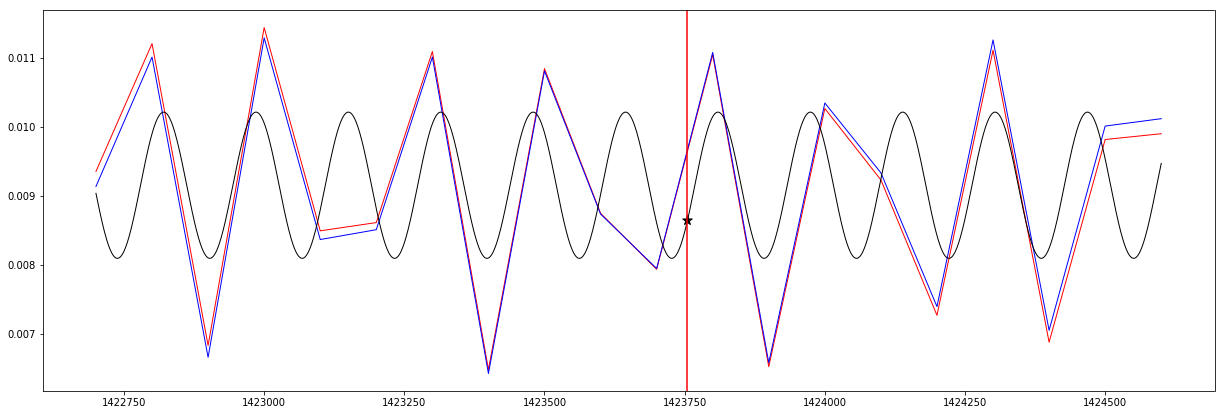

One Sine with varying period:  0.008641455098676053 0.6703524325755303
....
7 2
typ_fit:  0.0
Linear:  0.9581530018499569
....
7 3
typ_fit:  1.0


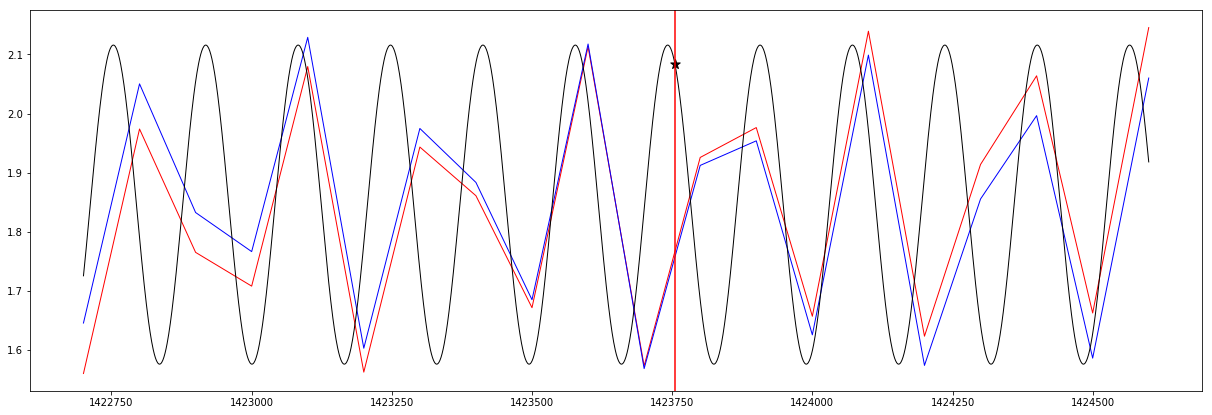

One Sine with varying period:  2.083361308483491 0.1399714906748213
....
7 4
typ_fit:  0.0
Linear:  1.7150703415839754
....
[3.01472581e+01 8.64145510e-03 9.58153002e-01 2.08336131e+00
 1.71507034e+00 3.91628698e+00]


In [14]:
########################################
# Interpolating Algorithm
# Provide the desired tau, and the body of the simulation

# Give tau the time of the interpolation
# Has to be smaller than 18E6
tau = 1423755

# Give the body of the interpolation
B = 7
# 1 Venus
# 2 Earth
# 3 Mars
# 4 Jupiter
# 5 Saturn
# 6 Uranus
# 7 Neptune
# 8 Pluto

#######################


# Hidden
# Params
I = B-1
i_tau = int(tau/100)
n = 20
i_0, i_1 = me.Adj_I(I_in=i_tau, N_in=n)
maxfev = 10000
ftol = 1e-8
init_vals = [0]
# Lists
beg_p = [0, 3, 6, 7, 10, 11]
beg_n = [0, 5, 8, 9, 12, 13]
beg_u = [0, 5, 8, 9, 12, 13]
beg_s = [0, 5, 10, 11, 14, 15]
beg_j = [0, 3, 8, 9, 14, 15]
beg_m = [0,1,2,3,4,5]
beg_e = [0,1,2,3,4,5]
beg_v = [0, 7, 8, 9, 10, 11]
begins = [beg_v,beg_e,beg_m,beg_j,beg_s,beg_u,beg_n,beg_p]
begin = begins[I]
paramfile = open(dir_params + 'param-' + str(name_label[B]) + '.txt').readlines()[5:]
# Arrays
typearr = np.zeros((8,5))
# READ IN TYPE FILE
typefile = open(dir_params + 'type-file.txt').readlines()
for i, line in enumerate(typefile):
    words = line.split()
    for j, w in enumerate(words[1:]):
        typearr[i, j] = w
# print (typearr[7])


# Hidden
# Params
n = 10
i_0, i_1 = me.Adj_I(I_in=i_tau, N_in=n)
# Read in ORIGINAL Brutus data
file = open(dir_data + 'run_N9_solar_system_jpl_0_0_0_t65Myr_e14_Lw128.diag', 'r')
body_o = file.readlines()[:]
steps = 2*n

time_o = np.zeros((2*n, 1))
cart_o = np.zeros((2*n, n_b, 7))
kepl_o = np.zeros((2*n, n_b, 7))

# Write array of cartesian parameters: Solar mass, AU, AU/Y
for i in range(steps): # for 2*n+1 time steps ...
    
    batch = body_o[batchsize*(i_0+i):batchsize*(i_0+i+1)]
    
    time_o[i, 0] = float((batch[0].split())[0])/6.28
    for j, line in enumerate(batch[1:-1]): # for all bodies incl sun...
        words = line.split()
        cart_o[i, j, :] = [float(x) for x in words]
        cart_o[i, j, 4:8] = 2*np.pi*cart_o[i, j, 4:8]

for i, step in enumerate(cart_o[:steps]):
    # Calculate COM:
    R_COM = np.zeros((1,3))
    V_COM = np.zeros((1,3))
    M = 0
    for j in range(8):
        m = SM_to_kg*step[j, 0]
        M = M + m
        R = AU_to_M*step[j, 1:4]
        V = AUpY_to_MpS*step[j, 4:7]
        R_COM = R_COM + m*R
        V_COM = V_COM + m*V
    r_COM = R_COM/M
    v_COM = V_COM/M   
    
    for j in range(9):
        m = SM_to_kg*step[j, 0]
        R = AU_to_M*step[j, 1:4]
        V = AUpY_to_MpS*step[j, 4:8]
        r = (R - r_COM)[0]
        v = (V - v_COM)[0]
        # a, e, vec_e, i, om, Om, M, E
        kepl_o[i, j, 0] = me.CartesianToKepler(m, r, v)[0]/AU_to_M
        for k in range(6):
            kepl_o[i, j, k+1] = me.CartesianToKepler(m, r, v)[k+2]

# Read in data 
data = np.zeros((2*n, 2))
data[:,0] = time_o[:, 0]

output = np.zeros((1,6))

for c in range(5):
#     Get type of fit for that combination of body-OEl
#     0: linear interpolation
#     1: Using one Sinusoid
#     2: Two sinusoids
#     3: Three sinuoids
    typ_fit = typearr[I,c]
    print (B, c)
    print ("typ_fit: ", typ_fit)
    
#     Get postion of needed params in paramfile
    n0 = begin[c]
    n1 = begin[c+1]
        
#     Linear Interpolation
    if typ_fit == 0.:
        dataLin = kepl_o[n:n+2, B, c]
        f = LinearInterpolate(tau, dataLin)
        output[0,c] = f
        print ("Linear: ", f)
        

#         Uncomment for plots
#         fig = plt.figure(figsize=(21,7))
#         ax = fig.add_subplot(111)
#         ax.scatter(time_o[n:n+2], dataLin, marker='*', s=10, c='r')
#         ax.plot(time_o[n:n+2], dataLin, lw=1, ms=0, c='b')
#         ax.axvline(tau, c='r')
#         ax.scatter(tau, f, c='k', marker='*', s=100)
#         plt.show()
#         plt.close()
        
    
#     Other type of fits
    elif typ_fit == 1.:
        data[:,1] = kepl_o[:, B, c]
        x = data[:,0]
        x2 = np.linspace(x[0], x[-1], n*200)
#         print (len(x), len(x2))
        y = data[:,1]
        mean_y = np.mean(y)
        y2 = detrend(y) + mean_y
#         Read in fit params
        params = paramfile[n0+1:n1]
########################################
#         Single Sine with constant period and constant amplitude
        if ((B==6 and (c==1 or c==3))
            or (B==5 and c==3)
            or (B==4 and c==0)
           ):
        
            per_args = [float(x) for x in params[0].split()]
            amp_args = [float(x) for x in params[1].split()]
            per = per_args[0]
            amp = amp_args[0]

            init_vals = [1,1]
            bounds = [[0, -np.inf], [2*np.pi, np.inf]]
            res, cov = curve_fit(FitOneSine, x, y2, p0=init_vals, maxfev=maxfev, ftol=ftol, bounds=bounds)
            args = per, amp, float(res[0]), mean_y
            fit = OneSin(x, args)
            r2 = me.Goodness(y, fit)
            f = abs(OneSin(tau, args))
            if (c==3 or c==4):
                f = np.mod(f, 2*np.pi)

#         Uncomment for plots
#             fig = plt.figure(figsize=(21,7))
#             ax = fig.add_subplot(111)
#             ax.plot(x, y, lw=1, ms=0, c='r')
#             ax.plot(x, y2, lw=1, ms=0, c='b')
#             ax.plot(x2, me.Sin(x2, args), lw=1, ms=0, c='k')
#             ax.axvline(tau, c='r')
#             ax.scatter(tau, me.Sin(tau, args), c='k', marker='*', s=100)
#             plt.show()
#             plt.close()

            output[0,c] = f
            
            print ("One Sine and period, amplitude const: ", f, r2)
#########################################         
# Single Sine with varying period and constant amplitude
        if ((B==8 and (c==0 or c==1 or c==3))
           or (B==7 and (c==1 or c==3))
           ):
        
            per_args = [float(x) for x in params[0].split()]
            amp_args = [float(x) for x in params[1].split()]
            per = OneSin(tau, per_args)
            amp = amp_args[0]
#             print (per_args, amp_args)
            init_vals = [1,1]
            bounds = [[0, -np.inf], [2*np.pi, np.inf]]
            res, cov = curve_fit(FitOneSine, x, y2, p0=init_vals, maxfev=maxfev, ftol=ftol, bounds=bounds)
            args = per, amp, float(res[0]), mean_y
            fit = OneSin(x, args)
            r2 = me.Goodness(y, fit)
            f = abs(OneSin(tau, args))
            if c==3 or c==4:
                f = np.mod(f, 2*np.pi)

#         Uncomment for plots
#             fig = plt.figure(figsize=(21,7))
#             ax = fig.add_subplot(111)
#             ax.plot(x, y, lw=1, ms=0, c='r')
#             ax.plot(x, y2, lw=1, ms=0, c='b')
#             ax.plot(x2, me.Sin(x2, args), lw=1, ms=0, c='k')
#             ax.axvline(tau, c='r')
#             ax.scatter(tau, me.Sin(tau, args), c='k', marker='*', s=100)
#             plt.show()
#             plt.close()

            output[0,c] = f
            print ("One Sine with varying period: ", f, r2)
########################################
#         Two Sines with one varying (1), one constant (2) period and constant amplitude
    elif typ_fit == 2.:
        data[:,1] = kepl_o[:, B, c]
        x = data[:,0]
        x2 = np.linspace(x[0], x[-1], n*200)
#         print (len(x), len(x2))
        y = data[:,1]
        mean_y = np.mean(y)
        y2 = detrend(y) + mean_y
#         Read in fit params
        params = paramfile[n0+1:n1]
    
        if ((B==7 and c==0)
#            or (b==4 and c==0)
           ):
            
            per1_args = [float(x) for x in params[0].split()]
            amp1_args = [float(x) for x in params[1].split()]
            per1 = OneSin(tau, per1_args)
            amp1 = amp1_args[0]
            per2_args = [float(x) for x in params[2].split()]
            amp2_args = [float(x) for x in params[3].split()]
            per2 = per2_args[0]
            amp2 = amp2_args[0]
            
            init_vals = [1,1,1]
            bounds = [[0, 0, -np.inf], [2*np.pi, 2*np.pi, np.inf]]
            res, cov = curve_fit(FitTwoSine, x, y2, p0=init_vals, maxfev=maxfev, ftol=ftol, bounds=bounds)
            args = per1, amp1, float(res[0]), mean_y, per2, amp2, float(res[1])
            
            f = abs(TwoSin(tau, args))
            if c==3 or c==4:
                f = np.mod(f, 2*np.pi)

#         Uncomment for plots            
#             fig = plt.figure(figsize=(21,7))
#             ax = fig.add_subplot(111)
#             ax.plot(x, y, lw=1, ms=0, c='r')
#             ax.plot(x, y2, lw=1, ms=0, c='b')
#             ax.plot(x2, me.AddedSines(x2, args), lw=1, ms=0, c='k')
#             ax.axvline(tau, c='r')
#             ax.scatter(tau, me.Sin(tau, args), c='k', marker='*', s=100)
#             plt.show()
#             plt.close()
            
#             print ("f from sine: ", f)
            output[0,c] = f
    
            print ("Two Sines with one varying period: ", f)
########################################
#         Two Sines with constant periods and amplitudes

        if ((B==6 and c==0)
            or (B==5 and (c==0 or c==1))
            or (B==4 and (c==1 or c==3))
           ):

            per1_args = [float(x) for x in params[0].split()]
            amp1_args = [float(x) for x in params[1].split()]
            per1 = per1_args[0]
            amp1 = amp1_args[0]
            per2_args = [float(x) for x in params[2].split()]
            amp2_args = [float(x) for x in params[3].split()]
            per2 = per2_args[0]
            amp2 = amp2_args[0]
            
            init_vals = [1,1,1]
            bounds = [[0, 0, -np.inf], [2*np.pi, 2*np.pi, np.inf]]
            res, cov = curve_fit(FitTwoSine, x, y2, p0=init_vals, maxfev=maxfev, ftol=ftol, bounds=bounds)
            args = per1, amp1, float(res[0]), mean_y, per2, amp2, float(res[1])

            f = abs(TwoSin(tau, args))
            if c==3 or c==4:
                f = np.mod(f, 2*np.pi)

#         Uncomment for plots           
#             fig = plt.figure(figsize=(21,7))
#             ax = fig.add_subplot(111)
#             ax.plot(x, y, lw=1, ms=0, c='r')
#             ax.plot(x, y2, lw=1, ms=0, c='b')
#             ax.plot(x2, me.AddedSines(x2, args), lw=1, ms=0, c='k')
#             ax.axvline(tau, c='r')
#             ax.scatter(tau, me.Sin(tau, args), c='k', marker='*', s=100)
#             plt.show()
#             plt.close()
            
#             print ("f from sine: ", f)
            output[0,c] = f
            print ("Two sines with all peridos constant: ", f)
########################################
#         Three Sines with constant periods and amplitudes
    elif typ_fit == 3.:
        data[:,1] = kepl_o[:, B, c]
        x = data[:,0]
        x2 = np.linspace(x[0], x[-1], n*200)
#         print (len(x), len(x2))
        y = data[:,1]
        mean_y = np.mean(y)
        y2 = detrend(y) + mean_y
#         Read in fit params
        params = paramfile[n0+1:n1]
    
        if (B==1 and c==0):
            
            per1_args = [float(x) for x in params[0].split()]
            amp1_args = [float(x) for x in params[1].split()]
            per1 = per1_args[0]
            amp1 = amp1_args[0]
            per2_args = [float(x) for x in params[2].split()]
            amp2_args = [float(x) for x in params[3].split()]
            per2 = per2_args[0]
            amp2 = amp2_args[0]
            per3_args = [float(x) for x in params[4].split()]
            amp3_args = [float(x) for x in params[5].split()]
            per3 = per3_args[0]
            amp3 = amp3_args[0]
            init_vals = [1,1,1,1]
            bounds = [[0, 0, 0, -np.inf], [2*np.pi, 2*np.pi, 2*np.pi, np.inf]]

            res, cov = curve_fit(FitThreeSine, x, y2, p0=init_vals, maxfev=maxfev, ftol=ftol, bounds=bounds)
            args = per1, amp1, float(res[0]), float(res[3]), per2, amp2, float(res[1]), per3, amp3, float(res[2])

            f = abs(ThreeSin(tau, args))
            if c==3 or c==4:
                f = np.mod(f, 2*np.pi)

#         Uncomment for plots                
#             fig = plt.figure(figsize=(21,7))
#             ax = fig.add_subplot(111)
#             ax.plot(x, y, lw=1, ms=0, c='r')
#             ax.plot(x, y2, lw=1, ms=0, c='b')
#             ax.plot(x2, me.ThreeAddedSines(x2, args), lw=1, ms=0, c='k')
#             ax.axvline(tau, c='r')
#             ax.scatter(tau, ThreeSin(tau, args), c='k', marker='*', s=100)
#             plt.show()
#             plt.close()
            
#             print ("f from sine: ", f)
            output[0,c] = f
            
            print ("Three sines: ", f)

#         Calculate Mean Anomaly
#     t0: time coordinate of the last snapshot before tau
    t0 = time_o[n,0]
    dt = tau - t0

#     Get orbital period at t0, tau from sma in kepl_o
    sma_t0 = kepl_o[n, B, 0]
    orbper_t0 = SMAtoPeriod(sma_t0)
    sma_tau = output[0,0]
    orbper_tau = SMAtoPeriod(sma_tau)

#     Calculate mean anomaly at tau m_tau
    m_t0 = kepl_o[n, B, 5]
    n_mean = MeanAngMotion(orbper_t0, orbper_tau)
    m_tau = np.mod(m_t0 + n_mean*dt, 2*np.pi)
    
    output[0, 5] = m_tau
    print ("....")
        
print (output[0])